## 【問題1】ラグランジュの未定乗数法による最急降下  

>SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 λ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。
>
>$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$
>
>ここで k(xi,xj)  はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。
>
>$
k(x_i, x_j) = x_{i}^{T} x_j
$
>
>条件として、更新毎に λi>=0を満たす必要があります。満たさない場合は 
λi=0とします。
>
>i,j : サンプルのインデックス
>
>λnewi : 更新後のi番目のサンプルのラグランジュ乗数
>
>λi : 更新前のi番目のサンプルのラグランジュ乗数
>
>α : 学習率
>
>λj : j番目のサンプルのラグランジュ乗数
>
>yi: i番目のサンプルのラベル
>
>yj : j番目のサンプルのラベル
>
>xi : i番目のサンプルの特徴量ベクトル
>
>xj : j番目のサンプルの特徴量ベクトル
>
>あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

In [1]:
import numpy as np

In [2]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.lam_list_
      ラグランジュ乗数

    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
        
    def fit(self, X, y):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
            
        # サンプル数
        m = X.shape[0]
        
        #　サンプル数分のラムダを用意
        self.lam_list_ = np.random.rand(m)
        
        # ランダム値に０.００１をかけて初期値を下げると精度が上がる
        #self.lam_list_ = np.random.rand(m)
        
        # 学習
        for _ in range(self.iter):
            self._gradient_descent(X, y, alpha = self.lr)
            #print(self.lam_list_)
        
        self.support_vector(X, y, threshold=self.threshold)
        
        
    def _gradient_descent(self, X, y, alpha=0.01):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # サンプル数
        m = X.shape[0]
        
        # for分外でまとめて更新？
        #new_lam_list = np.zeros(m)
        
        for i in range(m):
            sigma = 0
            # j のみ行列で計算する手もある
            for j in range(m):
                sigma += self.lam_list_[j]*y[i]*y[j]*self.kernel_calculation(X[i], X[j])
            new_lambda = self.lam_list_[i] + alpha * (1 - sigma)
            # for文中に更新？
            if new_lambda >= 0:
                self.lam_list_[i] = new_lambda
            else:
                self.lam_list_[i] = 0
                
            # for分外でまとめて更新？
            #if new_lambda >= 0:
            #    new_lam_list[i] = new_lambda
            #else:
            #    new_lam_list[i] = 0
            
        # for分外でまとめて更新？
        #self.lam_list_ = new_lam_list
    
    
    def kernel_calculation(self, Xi, Xj):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        Xi_re=Xi.reshape(-1,1)
        Xi_t=Xi_re.T
        
        kernel_func = Xi.T@Xj
        
        return kernel_func
    
        
    def support_vector(self, X, y, threshold=1e-5):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        # SVを抜き出しするためのフィルタを作成
        sv_filter = np.where(self.lam_list_ <  threshold, 0, self.lam_list_)
        
        # 以下の式でインデックスを指定して各配列に渡すことで抜き出すことも可能。
        # sv_filter = np.where(self.lam_list_ <  threshold)[0]
        # True, False でマスクするというやり方もある
        
        # 直接λを削除したくないのでコピー
        lam_del = self.lam_list_.copy()
        
        index_list = np.arange(self.lam_list_.shape[0])
        
        # フィルタを使ってSVに該当しないものを削除
        for i in reversed(range(len(sv_filter))):
            if sv_filter[i] <= 0:
                index_list = np.delete(index_list, i)
                X = np.delete(X, i, axis=0)
                lam_del = np.delete(lam_del, i)
                y = np.delete(y, i)
        
        # SVのデータを保管
        self.n_support_vectors = X.shape[0]
        self.index_support_vectors = index_list#.reshape(-1,1)
        self.X_sv = X
        self.lam_sv = lam_del
        self.y_sv = y
        
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        fx = X@self.X_sv[0]

        # X_test  サンプル数 
        m = X.shape[0]
        
        f = 0
        # サポートベクター数　回す
        for n in range(self.n_support_vectors):
            f += self.lam_sv[n]*self.y_sv[n]*self.kernel_calculation(X.T, self.X_sv[n])

        # ２分値に変換（今回のデータセット１が −１ or １ のため）
        pred = np.where(f <  0, -1, 1)
        
        return pred
    
    

In [3]:
# データ

X_train =  np.array([[ 7.72382751e-01, -2.29167329e+00],
 [-5.93349449e-01 , 1.66788336e+00],
 [-2.07648560e+00,  4.87468451e-01],
 [ 1.19226877e-01,  3.62537974e+00],
 [-3.13000578e+00, -1.56731551e-01],
 [-1.78109832e+00,  1.22224904e+00],
 [ 3.99770982e+00,  1.25164011e+00],
 [ 2.15604470e+00, -3.85824429e-01],
 [ 1.94741552e+00, -1.29638961e+00],
 [ 1.58757396e+00, -1.85989193e+00]])

y_train =  np.array([-1, 1 , 1 , 1,  1,  1, -1, -1, -1, -1])

X_test =  np.array([ [ 1.24814437e+00, -2.16798041e+00],
 [-2.61058479e+00 , 7.39246641e-01],
 [ 3.17316787e-01,  2.22551981e+00],
 [-1.35919625e+00 , 8.92051885e-01],
 [ 1.10298263e+00, -5.48525150e-01]])

y_test =  np.array([-1 , 1 , 1 , 1, -1])

クラス内に_gradient_descentメソッドを作成。  
fitメソッド内のfor文で呼び出して使用。

In [4]:
# インスタンス化 
SVM = ScratchSVMClassifier(10, 0.1, threshold=1e-5)

In [5]:
SVM.fit(X_train, y_train)
print("計算されたラグランジュ乗数(λ)：\n{}".format(SVM.lam_list_))

計算されたラグランジュ乗数(λ)：
[0.         0.16615813 0.03550072 0.         0.         0.
 0.00617792 0.01872517 0.05020126 0.        ]


## 【問題2】サポートベクターの決定  
>計算したラグランジュ乗数 λ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。
>
>閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

クラス内にsupport_vectorメソッドを作成。  
fitメソッド内から呼び出して使用。  
(ラグランジュ乗数を求めたあとにサポートベクターを抜き出す。)

In [6]:
# fit関数にsupport_vector関数を作成し、サポートベクターを選び出して情報を保管
print("サポートベクター数:\n{}".format(SVM.n_support_vectors))
print("サポートベクターのインデックス:\n{}".format(SVM.index_support_vectors))
print("サポートベクターの特徴量:\n{}".format(SVM.X_sv))
print("サポートベクターの乗数:\n{}".format(SVM.lam_sv))
print("サポートベクターのラベル:\n{}".format(SVM.y_sv))

サポートベクター数:
5
サポートベクターのインデックス:
[1 2 6 7 8]
サポートベクターの特徴量:
[[-0.59334945  1.66788336]
 [-2.0764856   0.48746845]
 [ 3.99770982  1.25164011]
 [ 2.1560447  -0.38582443]
 [ 1.94741552 -1.29638961]]
サポートベクターの乗数:
[0.16615813 0.03550072 0.00617792 0.01872517 0.05020126]
サポートベクターのラベル:
[ 1  1 -1 -1 -1]


## 【問題3】推定  
>推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f(x) の符号が分類結果です。



In [7]:
y_pred = SVM.predict(X_test)
print("予測値: {}".format(y_pred))

予測値: [-1  1  1  1 -1]


## 【問題4】学習と推定  

>機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。
>scikit-learnによる実装と比べ、正しく動いているかを確認してください。
>AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

#### データセット１

In [8]:
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

# 処理用
X_ds1 = X
y_ds1 = y

In [9]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータを７５：２５で分割
X_train_ds1, X_test_ds1, y_train_ds1, y_test_ds1 = train_test_split(X_ds1, y_ds1, test_size=0.2, random_state=0)

print("X_trainの形は：{}".format(X_train_ds1.shape))
print("y_trainの形は：{}".format(y_train_ds1.shape))
print("X_testの形は：{}".format(X_test_ds1.shape))
print("y_testの形は：{}".format(y_test_ds1.shape))

X_trainの形は：(400, 2)
y_trainの形は：(400,)
X_testの形は：(100, 2)
y_testの形は：(100,)


In [10]:
from sklearn.preprocessing import StandardScaler

# 標準化クラスをインスタンス化
scaler = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler.fit(X_train)

# 標準化
X_train_scaled = scaler.transform(X_train_ds1)
X_test_scaled = scaler.transform(X_test_ds1)

In [11]:
# インスタンス化 (num_iter, lr, kernel='linear', threshold=1e-5, verbose=False)
SVM_ds1 = ScratchSVMClassifier(100, 0.1, threshold=1e-5)
SVM_ds1.fit(X_train_scaled, y_train_ds1)

In [12]:
print("サポートベクター数:\n{}".format(SVM_ds1.n_support_vectors))
print("サポートベクターのインデックス:\n{}".format(SVM_ds1.index_support_vectors))
print("サポートベクターの特徴量:\n{}".format(SVM_ds1.X_sv))
print("サポートベクターの乗数:\n{}".format(SVM_ds1.lam_sv))
print("サポートベクターのラベル:\n{}".format(SVM_ds1.y_sv))

サポートベクター数:
6
サポートベクターのインデックス:
[  1 151 245 262 264 309]
サポートベクターの特徴量:
[[ 0.00653395  0.98250279]
 [-0.38097252  0.30289011]
 [ 0.46621748 -0.25693555]
 [ 0.32457553 -0.4883676 ]
 [-0.60751684  0.06749098]
 [-0.63115249  0.00734941]]
サポートベクターの乗数:
[0.27534915 1.3953871  0.59553026 0.32436815 0.41581539 0.65549641]
サポートベクターのラベル:
[ 1  1 -1 -1  1  1]


In [13]:
y_pred_ds1 = SVM_ds1.predict(X_test_ds1)
print("自作関数による予測値\n{}".format(y_pred_ds1))

自作関数による予測値
[-1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1
 -1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1
  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1
  1  1 -1  1]


In [14]:
#from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import pandas as pd

In [15]:
# 精度をまとめるための空のリストを用意
verification_svm = ['My_SVM']

#Accuracy（正解率）
verification_svm.append(accuracy_score(y_test_ds1, y_pred_ds1))

#Precision（適合率）
verification_svm.append(precision_score(y_test_ds1, y_pred_ds1))

#Recall（再現率）
verification_svm.append(recall_score(y_test_ds1, y_pred_ds1))

#F値
verification_svm.append(f1_score(y_test_ds1, y_pred_ds1))

print("自作関数の精度\n{}".format(verification_svm))

自作関数の精度
['My_SVM', 1.0, 1.0, 1.0, 1.0]


### scikit-learnによる分類

In [16]:
#SVM

svm_sk = SVC(gamma='auto')
svm_sk.fit(X_train_ds1, y_train_ds1)
y_pred_sk = svm_sk.predict(X_test_ds1)
print("SVMによる予測値\n{}".format(y_pred_sk))


SVMによる予測値
[-1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1
 -1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1
  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1
  1  1 -1  1]


In [17]:
verification_svm_sk = ['sickt-learn_SVM']

#Accuracy（正解率）
verification_svm_sk.append(accuracy_score(y_test_ds1, y_pred_sk))

#Precision（適合率）
verification_svm_sk.append(precision_score(y_test_ds1, y_pred_sk))

#Recall（再現率）
verification_svm_sk.append(recall_score(y_test_ds1, y_pred_sk))

#F値
verification_svm_sk.append(f1_score(y_test_ds1, y_pred_sk))

print("sickt-learnの精度\n{}".format(verification_svm_sk))

sickt-learnの精度
['sickt-learn_SVM', 1.0, 1.0, 1.0, 1.0]


In [18]:
# 表を作成するために計算結果を２次元配列にする
verification_result = [
            verification_svm, 
            verification_svm_sk, 
        ]

# 行と列のインデックスようのリストを用意
data_columns=['Model', 'Accuracy（正解率）', 'Precision（適合率）', 'Recall（再現率）', 'F値' ]

# pandas のデータフレームにする
df_verification = pd.DataFrame(data=verification_result, columns=data_columns)

display(df_verification)

,Model,Accuracy（正解率）,Precision（適合率）,Recall（再現率）,F値
0,My_SVM,1.0,1.0,1.0,1.0
1,sickt-learn_SVM,1.0,1.0,1.0,1.0


## 【問題5】決定領域の可視化  
>決定領域を可視化してください。
>
>以下の例のようにサポートベクターは異なる色で示してください。



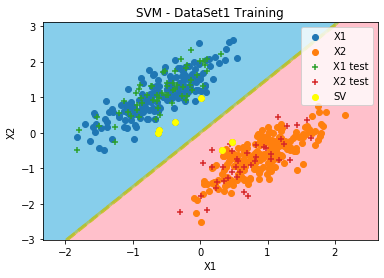

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, arget_names=['X1', 'X2']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title('SVM - DataSet1 Training')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    plt.scatter(X_train_scaled[y_train_ds1 == 1, 0], X_train_scaled[y_train_ds1 == 1, 1], label="X1")
    plt.scatter(X_train_scaled[y_train_ds1 == -1, 0], X_train_scaled[y_train_ds1 == -1, 1], label="X2")
    plt.scatter(X_test_scaled[y_test_ds1 == 1, 0], X_test_scaled[y_test_ds1 == 1, 1], marker="+", label="X1 test")
    plt.scatter(X_test_scaled[y_test_ds1 == -1, 0], X_test_scaled[y_test_ds1 == -1, 1], marker="+", label="X2 test")

    plt.scatter(SVM_ds1.X_sv[:, 0], SVM_ds1.X_sv[:, 1], c='yellow', label="SV")#, 'x'

    plt.legend()
    plt.show()

decision_region(X_train_scaled, y_train_ds1, SVM_ds1)

## 【問題6】（アドバンス課題）多項式カーネル関数の作成  
>最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。
>
>「線形カーネルの式」
>
>$$
k(x_i, x_j) = x_{i}^{T} x_j
$$
>
>「多項式カーネルの式」
>
>$$
k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}
$$
>
>
>$
\gamma, \theta_0 , d = はハイパーパラメータです。
$
>
>$
線形カーネルは \gamma = 1, \theta_0 = 0, d = 1  の場合の多項式カーネルと等しいと言えます。
$

多項式カーネルは 𝛾=1、𝜃=0、𝑑=1　の時、 線形カーネルと等しいため、  
同じ関数を用い、パラメーターの選択によりこれらを区別する。  
polynomial_kernelというメソッドを新たに作成し、fitメソッド内で  
指定関数が 'linear' の場合に上記のパラメーターが与えられるように作成。

In [20]:
import sys

In [21]:
class ScratchSVMClassifier_poly():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.lam_list_
    　　ラグランジュ乗数
    self.gamma
    　　ガンマ
    self.theta
    　　シータ
    self.d 
    　　d

    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
        
    def fit(self, X, y, gamma=1, theta=0, d=1):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
            
        # サンプル数
        m = X.shape[0]
        
        #　サンプル数分のラムダを用意
        self.lam_list_ = np.random.rand(m)
        
        # 【問題６】
        # カーネル関数の選択
        if self.kernel == 'linear':
            self.gamma = 1
            self.theta = 0
            self.d = 1
        elif self.kernel == 'poly':
            self.gamma = gamma
            self.theta = theta
            self.d = d
        else:
            print("カーネルの選択が間違っています。やり直してください。")
            sys.exit()
        
        for _ in range(self.iter):
            self._gradient_descent(X, y, alpha = self.lr)
        
        self.support_vector(X, y, threshold=self.threshold)
        
        
    def _gradient_descent(self, X, y, alpha = 0.01):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # サンプル数
        m = X.shape[0]
        
        for i in range(m):
            sigma = 0
            for j in range(m):
                #  元の式
                #sigma += self.lam_list_[j]*y[i]*y[j]*self.kernel_calculation(X[i], X[j])
                # 【問題６】
                #  カーネル選択 ('linear'の場合は、gamma=1, theta=0, d=1)
                sigma += self.lam_list_[j]*y[i]*y[j]*self.polynomial_kernel(X[i], X[j])
            new_lambda = self.lam_list_[i] + alpha * (1 - sigma)
            if new_lambda >= 0:
                self.lam_list_[i] = new_lambda
            else:
                self.lam_list_[i] = 0
    
    
    def kernel_calculation(self, Xi, Xj):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        Xi_re=Xi.reshape(-1,1)
        Xi_t=Xi_re.T
        
        kernel_func = Xi.T@Xj
        
        return kernel_func
    
    
    # 【問題６】
    def polynomial_kernel(self, Xi, Xj):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        Xi_re=Xi.reshape(-1,1)
        Xi_t=Xi_re.T
        
        # 多項式カーネルの式
        polynomial_kernel = (self.gamma*Xi.T@Xj + self.theta)**self.d
        
        return polynomial_kernel
    
        
    def support_vector(self, X, y, threshold=1e-5):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        sv_filter = np.where(self.lam_list_ <  threshold, 0, self.lam_list_)
        
        index_list = np.arange(self.lam_list_.shape[0])
        lam_del = self.lam_list_.copy()
        
        for i in reversed(range(len(sv_filter))):
            if sv_filter[i] <= 0:
                index_list = np.delete(index_list, i)
                X = np.delete(X, i, axis=0)
                lam_del = np.delete(lam_del, i)
                y = np.delete(y, i)
        
        self.n_support_vectors = X.shape[0]
        self.index_support_vectors = index_list#.reshape(-1,1)
        self.X_sv = X
        self.lam_sv = lam_del
        self.y_sv = y
        
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        fx = X@self.X_sv[0]
        
        # X_test  サンプル数 
        m = X.shape[0]
        
        f = 0
        # サポートベクター数　回す
        for n in range(self.n_support_vectors):
            f += self.lam_sv[n]*self.y_sv[n]*self.polynomial_kernel(X.T, self.X_sv[n])

        pred = np.where(f <  0, -1, 1)
        
        return pred
    
    

In [22]:
# インスタンス化
# def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
SVM_poly = ScratchSVMClassifier_poly(100, 0.01, kernel='poly', threshold=1e-5)

#def fit(self, X, y, X_val=None, y_val=None, gamma=1, theta=0, d=1):
SVM_poly.fit(X_train_scaled, y_train_ds1, gamma=2, theta=1, d=2)


In [23]:
print("サポートベクター数:\n{}".format(SVM_poly.n_support_vectors))
print("サポートベクターのインデックス:\n{}".format(SVM_poly.index_support_vectors))
print("サポートベクターの特徴量:\n{}".format(SVM_poly.X_sv))
print("サポートベクターの乗数:\n{}".format(SVM_poly.lam_sv))
print("サポートベクターのラベル:\n{}".format(SVM_poly.y_sv))


y_pred_poly = SVM_poly.predict(X_test_ds1)
print("自作関数による予測値\n{}".format(y_pred_poly))


verification_svm_poly = []

#Accuracy（正解率）
verification_svm_poly.append(accuracy_score(y_test_ds1, y_pred_poly))

#Precision（適合率）
verification_svm_poly.append(precision_score(y_test_ds1, y_pred_poly))

#Recall（再現率）
verification_svm_poly.append(recall_score(y_test_ds1, y_pred_poly))

#F値
verification_svm_poly.append(f1_score(y_test_ds1, y_pred_poly))


print("多項式カーネルの精度\n{}".format(verification_svm_poly))


サポートベクター数:
9
サポートベクターのインデックス:
[  1  68  78 151 245 262 264 309 364]
サポートベクターの特徴量:
[[ 0.00653395  0.98250279]
 [ 0.38159119 -0.45291014]
 [ 0.9179026   0.09234639]
 [-0.38097252  0.30289011]
 [ 0.46621748 -0.25693555]
 [ 0.32457553 -0.4883676 ]
 [-0.60751684  0.06749098]
 [-0.63115249  0.00734941]
 [-0.07554499  0.88966817]]
サポートベクターの乗数:
[0.0159743  0.09615164 0.00655191 0.18743665 0.17151754 0.12773194
 0.09489697 0.10751452 0.03012416]
サポートベクターのラベル:
[ 1 -1 -1  1 -1 -1  1  1  1]
自作関数による予測値
[-1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1
 -1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1
  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1
  1  1 -1  1]
多項式カーネルの精度
[1.0, 1.0, 1.0, 1.0]


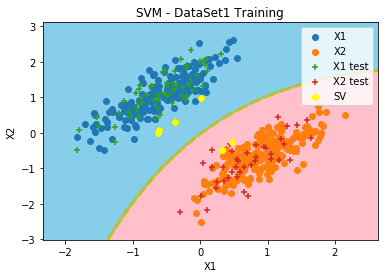

In [24]:
decision_region(X_train_scaled, y_train_ds1, SVM_poly)

以上